# Fuel Analysis

#### Library init and setup

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

#### Data standarization and storage

**Teams data structure**

`teams: dict` - Contains the dict of teams, with a *team* dict per each team

`team: dict` - Contains the team's data in keys, which are:
* `F_TYPE: str` - Fuel Type
* `FEF: float` - Fuel Efficiency Factor
* `DISPLACEMENT: str` - Engine Displacement (cc)
* `ACC_SCORE: float` - Acceleration event score
* `ACC_DNF: bool` - DNF/DNA in Acceleration event participation
* `END_SCORE: float` - Endurance event score
* `END_DNF: bool` - DNF/DNA in Endurance event participation

_Note_: Certain teams participated in Fuel Efficiency Event, but not in others, so a key's existence must be validated to avoid errors.

In [3]:
# Dict to contain each team's data in their own dict
teams = {}
fuel_path = "FSAE_2023_results/FSAE_2023_results - Efficiency results.csv"
acc_path = "FSAE_2023_results/FSAE_2023_results - Acceleration event results.csv"
end_path = "FSAE_2023_results/FSAE_2023_results - Endurance event results.csv"
info_path = "FSAE_2023_results/FSAE_2023_results - Team information.csv"

# Loading data of teams in Fuel Efficiency Event into dict
with open(fuel_path) as file:
    reader = csv.DictReader(file)

    for entry in reader:
        if float(entry["Average Adjusted Laptime"]):
            FEF_value = entry["Fuel Efficiency Factor"]
            # Cast value if it's != "", set it to 0 otherwise
            FEF = float(FEF_value) if FEF_value != "" else 0
            # Add Fuel type and FEF to team data
            teams[entry["Team"]] = {"F_TYPE": entry["Fuel Type"],"FEF": FEF}

# Loading each team's engine displacement
with open(info_path) as file:
    reader = csv.DictReader(file)

    for entry in reader:
        # Validate whether team participated in Fuel Efficiency Event 
        if entry["Team"] in teams:
            teams[entry["Team"]]["DISCPLACEMENT"] = entry["Engine Displacement (cc)"]

# Loading each team's acceleration score and DNF in said event
with open(acc_path) as file:
    reader = csv.DictReader(file)

    for entry in reader:
        # Validate wether team participated in Fuel Efficiency Event
        if entry["Team"] in teams:
            # Checking DNA/DNA in run
            values = [entry["Run #1 Time"], 
                      entry["Run #2 Time"], 
                      entry["Run #3 Time"],
                      entry["Run #4 Time"]]
            DNF = True if "DNA" in values or "DNF" in values else False

            # Add acceleration score and DNA/DNF data
            teams[entry["Team"]]["ACC_SCORE"] = float(entry["Score"])
            teams[entry["Team"]]["ACC_DNF"] = DNF

# Loading each team's endurance score and DNF in said event
with open(end_path) as file:
    reader = csv.DictReader(file)

    for entry in reader:
        # Validate wether team participated in Fuel Efficiency Event
        if entry["Team"] in teams:
            DNF = True if entry["Adjusted Time"] == "DNF" else False

            # Add endurance score and DNA/DNF data
            teams[entry["Team"]]["END_SCORE"] = float(entry["Endurance Score"])
            teams[entry["Team"]]["END_DNF"] = DNF

print(f"Total teams: {len(teams)}\n")

for team in teams:
    print(team, teams[team])


Total teams: 56

South Dakota State Univ {'F_TYPE': 'E85', 'FEF': 0.697, 'DISCPLACEMENT': '670', 'END_SCORE': 30.8, 'END_DNF': False}
Univ of North Carolina - Charlotte {'F_TYPE': '100', 'FEF': 0.688, 'DISCPLACEMENT': '450', 'ACC_SCORE': 63.52, 'ACC_DNF': False, 'END_SCORE': 254.8, 'END_DNF': False}
Univ of Calif - San Diego {'F_TYPE': '93', 'FEF': 0.66, 'DISCPLACEMENT': '700', 'ACC_SCORE': 79.63, 'ACC_DNF': False, 'END_SCORE': 253.5, 'END_DNF': False}
Univ of Akron {'F_TYPE': 'E85', 'FEF': 0.647, 'DISCPLACEMENT': '450', 'ACC_SCORE': 46.74, 'ACC_DNF': False, 'END_SCORE': 163.0, 'END_DNF': False}
Univ of Calif - Berkeley {'F_TYPE': 'E85', 'FEF': 0.626, 'DISCPLACEMENT': '450', 'ACC_SCORE': 56.14, 'ACC_DNF': False, 'END_SCORE': 18.0, 'END_DNF': True}
California Baptist University {'F_TYPE': '100', 'FEF': 0.624, 'DISCPLACEMENT': '690', 'ACC_SCORE': 67.6, 'ACC_DNF': False, 'END_SCORE': 61.6, 'END_DNF': False}
Univ of Colorado - Boulder {'F_TYPE': '93', 'FEF': 0.624, 'DISCPLACEMENT': '689', 

### Fuel used against average fuel efficiency factor (FEF)

FEF is calculated with the following formula:

FEF = (Tmin/Tyours) * (CO2min/CO2yours) * (Lapyours^2/Laptotal^2)

Being Tmin and C02min the least metric achieved in the competition, and yours being the one the team got.

Average FEF for each fuel type:
- 93: 0.4924, 17 teams.
- 100: 0.475, 11 teams.
- E85: 0.52, 12 teams.


(0.0, 0.6)

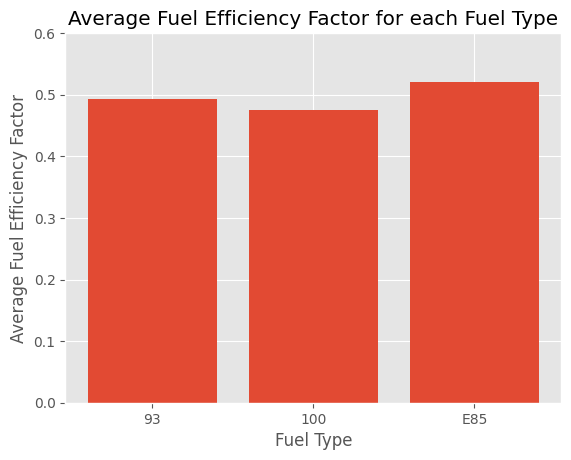

In [4]:
# Calculate average FEF for each fuel type
fuel_types = {"93": [], "100": [], "E85": []}

for team in teams:
    if teams[team]["FEF"] != 0:
        fuel_types[teams[team]["F_TYPE"]].append(teams[team]["FEF"])

print("Average FEF for each fuel type:")

for fuel in fuel_types:
    avrg = np.mean(fuel_types[fuel])
    print(f"- {fuel}: {round(avrg,4)}, {len(fuel_types[fuel])} teams.")
    fuel_types[fuel] = avrg

# Plot average FEF for each fuel type
fig, ax = plt.subplots()
ax.bar(fuel_types.keys(), fuel_types.values())

# Style the plot
ax.set_title("Average Fuel Efficiency Factor for each Fuel Type")
ax.set_xlabel("Fuel Type")
ax.set_ylabel("Average Fuel Efficiency Factor")
ax.set_ylim(0, 0.6)



### * Fuel categorization: Average FEF per engine displacement

 **NOTE:** This is *really* biased, needs more data from previous years to actually categorize properly


Average FEF for each fuel type and engine displacement:

E85:
- 450cc: 0.6017, 3 teams.
- 600cc: 0.3827, 6 teams.

100:
- 600cc: 0.29, 8 teams.
- 636cc: 0.344, 3 teams.

93:
- 600cc: 0.2763, 18 teams.


[None, None, None, None, None, None]

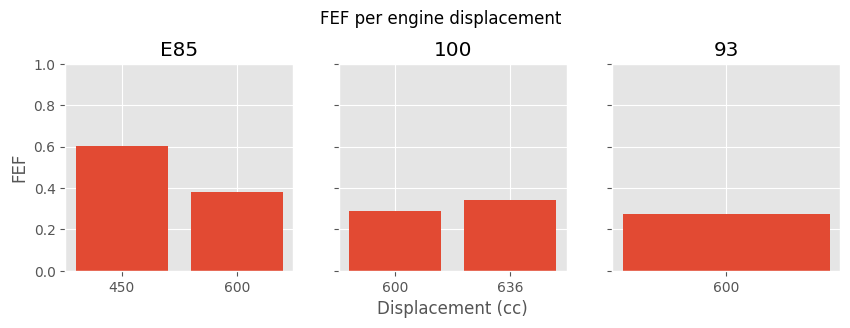

In [98]:
# Dict of fuel types with list of FEF per engine displacement
fuels = {}

# Populate the dict
for team in teams:
    fuel = teams[team]["F_TYPE"]
    displacement = teams[team]["DISCPLACEMENT"]
    fef = teams[team]["FEF"]
    # Initializing the dict and list if not present
    if fuel not in fuels:
        fuels[fuel] = dict()
        
    if displacement not in fuels[fuel]:
        fuels[fuel][displacement] = []
        fuels[fuel][displacement].append(fef)
    else:
        fuels[fuel][displacement].append(fef)

# Calculate average (more than 2 occurences) FEF for each fuel type and engine displacement
print("\nAverage FEF for each fuel type and engine displacement:")

for fuel in fuels:
    print(f"\n{fuel}:")
    for displacement in fuels[fuel]:
        # Compute averages
        if len(fuels[fuel][displacement]) > 2:
            avrg = np.mean(fuels[fuel][displacement])
            print(f"- {displacement}cc: {round(avrg,4)}, {len(fuels[fuel][displacement])} teams.")
            fuels[fuel][displacement] = avrg

# Sort the dict by engine displacement
for fuel in fuels:
    fuels[fuel] = dict(sorted(fuels[fuel].items()))

# Graph the FEF
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))

fig.subplots_adjust(top=0.8)
fig.suptitle("FEF per engine displacement")

# E85
E85 = fuels["E85"]
E85_X = [x for x in E85.keys() if isinstance(E85[x], float)]
E85_Y = [E85[x] for x in E85_X]

ax1.set_title("E85")
ax1.set_ylabel("FEF")

ax1.bar(E85_X, E85_Y)

#100
f100 = fuels["100"]
f100_X = [x for x in f100.keys() if isinstance(f100[x], float)]
f100_Y = [f100[x] for x in f100_X]

ax2.set_title("100")
ax2.set_xlabel("Displacement (cc)")

ax2.bar(f100_X, f100_Y)

#93
f93 = fuels["93"]
f93_X = [x for x in f93.keys() if isinstance(f93[x], float)]
f93_Y = [f93[x] for x in f93_X]

ax3.set_title("93")

ax3.bar(f93_X, f93_Y)

# Style the plots with same y axis
# Set up y axis
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Set y axis ticks to be visible only on the first plot
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)


### FEF - Performance scores and Reliability per event (Acceleration, Endurance)

In [5]:
# Categorize data from participating teams 
E85_teams = {team:teams[team] for team in teams if teams[team]["F_TYPE"] == "E85"}
f100_teams = {team:teams[team] for team in teams if teams[team]["F_TYPE"] == "100"}
f93_teams = {team:teams[team] for team in teams if teams[team]["F_TYPE"] == "93"}

teams_categories = [E85_teams, f100_teams, f93_teams]

E85_results = {"ACC_teams": 0, "ACC_MEAN": [], "ACC_DNF": [], "END_teams": 0, "END_MEAN": [], "END_DNF": []}
f100_results = {"ACC_teams": 0, "ACC_MEAN": [], "ACC_DNF": [], "END_teams": 0, "END_MEAN": [], "END_DNF": []}
f93_results = {"ACC_teams": 0, "ACC_MEAN": [], "ACC_DNF": [], "END_teams": 0, "END_MEAN": [], "END_DNF": []}

results_categories = [E85_results, f100_results, f93_results]

# Compute average scores and reliability per event
# Iterate over lists
for i in range(len(teams_categories)):
    # Iterate over teams dicts
    for team in teams_categories[i]:
        # Add scores and DNFs to results if the team participated in the event
        if "ACC_SCORE" in teams_categories[i][team].keys():
            results_categories[i]["ACC_teams"] +=1
            results_categories[i]["ACC_MEAN"].append(teams_categories[i][team]["ACC_SCORE"])
            results_categories[i]["ACC_DNF"].append(teams_categories[i][team]["ACC_DNF"])
        if "END_SCORE" in teams_categories[i][team].keys():
            results_categories[i]["END_teams"] +=1
            results_categories[i]["END_MEAN"].append(teams_categories[i][team]["END_SCORE"])
            results_categories[i]["END_DNF"].append(teams_categories[i][team]["END_DNF"])

for i in range(len(results_categories)):
    results_categories[i]["ACC_MEAN"] = np.mean(results_categories[i]["ACC_MEAN"])
    results_categories[i]["ACC_DNF"] = np.sum(results_categories[i]["ACC_DNF"]) / len(results_categories[i]["ACC_DNF"])
    results_categories[i]["END_MEAN"] = np.mean(results_categories[i]["END_MEAN"])
    results_categories[i]["END_DNF"] = np.sum(results_categories[i]["END_DNF"]) / len(results_categories[i]["END_DNF"])

# Print results
print("Performance and reliability per fuel type:")

def print_results(fuel:str, category_teams:dict, category_results:dict):
    print("\n" + fuel + f", {len(category_teams)} teams total")
    print(f" Acceleration - {category_results['ACC_teams']} teams")
    print(f"- Acceleration mean: {category_results['ACC_MEAN']:.2f}")
    print(f"- Acceleration DNFs: {category_results['ACC_DNF']:.2f}")
    print(f" Endurance - {category_results['END_teams']} teams")
    print(f"- Endurance mean: {category_results['END_MEAN']:.2f}")
    print(f"- Endurance DNF: {category_results['END_DNF']:.2f}")

print_results("E85", E85_teams, E85_results)
print_results("100", f100_teams, f100_results)
print_results("93", f93_teams, f93_results)

Performance and reliability per fuel type:

E85, 14 teams total
 Acceleration - 13 teams
- Acceleration mean: 67.90
- Acceleration DNFs: 0.08
 Endurance - 14 teams
- Endurance mean: 115.76
- Endurance DNF: 0.29

100, 16 teams total
 Acceleration - 14 teams
- Acceleration mean: 60.07
- Acceleration DNFs: 0.50
 Endurance - 16 teams
- Endurance mean: 108.34
- Endurance DNF: 0.12

93, 26 teams total
 Acceleration - 23 teams
- Acceleration mean: 65.70
- Acceleration DNFs: 0.22
 Endurance - 26 teams
- Endurance mean: 109.63
- Endurance DNF: 0.12


(0.0, 1.0)

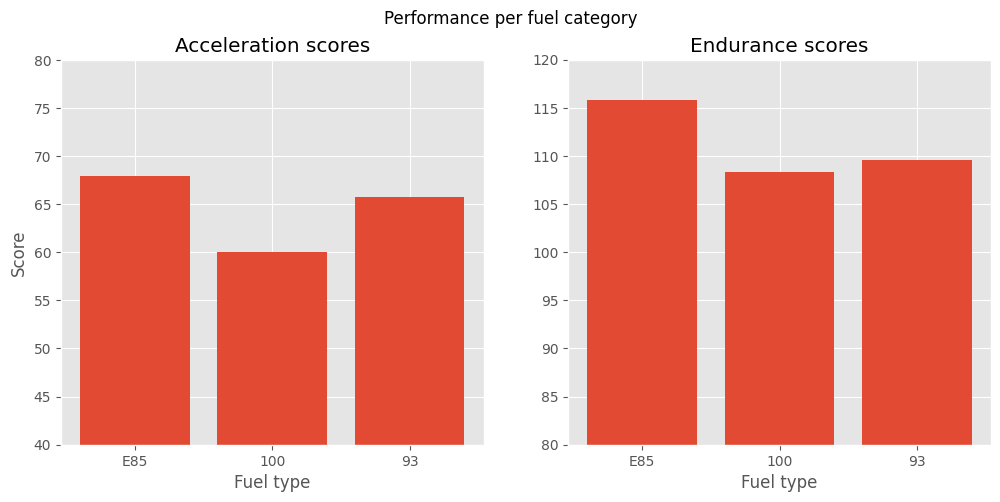

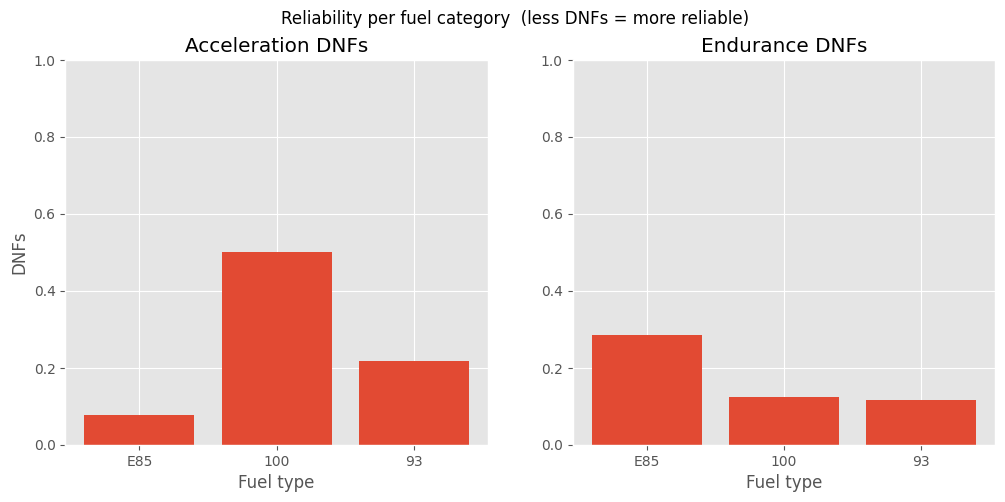

In [100]:
# Plot performance per category
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

fig.suptitle("Performance per fuel category")

# Plot acceleration scores
X = ["E85", "100", "93"]
ax1.bar(X, [category['ACC_MEAN'] for category in results_categories])

# Style plot
ax1.set_title("Acceleration scores")
ax1.set_ylabel("Score")
ax1.set_xlabel("Fuel type")


# Plot endurance scores
ax2.bar(X, [category['END_MEAN'] for category in results_categories])

# Style plot
ax2.set_title("Endurance scores")
ax2.set_xlabel("Fuel type")


# Plot reliability per category
fig, (ax3, ax4) = plt.subplots(1,2, figsize=(12,5))

fig.suptitle("Reliability per fuel category  (less DNFs = more reliable)")

# Plot acceleration DNFs
ax3.bar(X, [category['ACC_DNF'] for category in results_categories])

# Style plot
ax3.set_title("Acceleration DNFs")
ax3.set_ylabel("DNFs")
ax3.set_xlabel("Fuel type")

# Plot acceleration DNFs
ax4.bar(X, [category['END_DNF'] for category in results_categories])

# Style plot
ax4.set_title("Endurance DNFs")
ax4.set_xlabel("Fuel type")

# Set y limits
ax1.set_ylim(40, 80)
ax2.set_ylim(80, 120)
ax3.set_ylim(0,1)
ax4.set_ylim(0,1)

### Conclusive Remarks

It's important to consider that this analysis is made with the data from teams that finished the endurance event and thus, have an FEF.

Consequently, while the data is valid for those teams that got to that phase, facts beyond the plotted data becomes relevant.

For example, while the 100 fuel FEF, event scores and reliability are lower than a commonly known inferior fuel (93), this could surmount to the fact that the teams using 100 fuel had problems with using the fuel or adapting the power unit to it, rather than the potential power and efficiency of said fuel.